In [1]:
import networkx as nx
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
from networkx.generators.classic import star_graph
import scipy.stats as stats
from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt

import powerlaw

In [6]:
@py_random_state(2)
def barabasi_albert(n, m, seed=None, initial_graph=None):
    """Returns a random graph using Barabási–Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási–Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        source += 1
    return G

Random Graph

In [3]:
N = 1000
P = 0.25

G_r = nx.erdos_renyi_graph(N, P)
while min([d for n, d in G_r.degree()]) == 0:
          G_r = nx.erdos_renyi_graph(N, P)

k = np.arange(min([d for n,d in G_r.degree]), max([d for n,d in G_r.degree])+1)
p = [0]*len(k)

k_mean =sum(k)/len(k)

for i in range(len(k)):
    for n,d in G_r.degree:
        if k[i] == d:
            p[i] += 1
norm = sum(p)            

            
for i in range(len(p)):
    p[i] = p[i]/norm

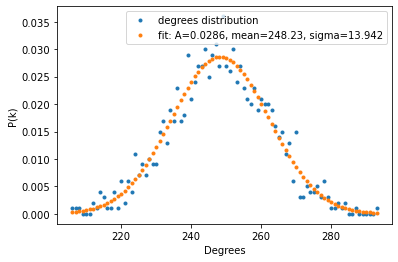

 - Data mean: 249.5
 - Mean from gaussian fit: 248.22996213039937 +/- 13.941636066118543
 - Std.dev. from poissonian fit: 13.941636066118543


Power_divergenceResult(statistic=0.061934304667617575, pvalue=1.0)

In [4]:
def gaus_law(x, a, mu=0, sigma=1):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

poptGaus, pcovGaus = curve_fit(gaus_law, k, p, 
                                         p0 = [1,k_mean, 1])

fit_function = gaus_law(k, *poptGaus)

fig, ax = plt.subplots()
ax.plot(k, p, '.', label = 'degrees distribution')
ax.set_xlabel("Degrees")
ax.set_ylabel("P(k)")      
ax.plot(k, fit_function, '.',
               label = f"fit: A={round(poptGaus[0],4)}, mean={round(poptGaus[1],3)}, sigma={round(poptGaus[2],3)}")
ax.legend()

plt.show()



print(" - Data mean:", k_mean)
print(" - Mean from gaussian fit:", poptGaus[1], '+/-', poptGaus[2])
print(" - Std.dev. from poissonian fit:", poptGaus[2])

stats.chisquare(p,fit_function)



Scale-free

[39804, 20386, 11316, 7009, 4821, 3333, 2469, 1772, 1421, 1046, 868, 730, 605, 487, 413, 339, 329, 259, 226, 211, 143, 153, 126, 133, 113, 110, 79, 86, 82, 78, 64, 55, 45, 57, 45, 39, 27, 27, 29, 29, 33, 22, 32, 22, 12, 25, 17, 15, 17, 12, 17, 17, 9, 7, 10, 12, 12, 15, 11, 11, 12, 9, 3, 4, 9, 6, 7, 7, 14, 7, 6, 6, 8, 4, 8, 4, 8, 3, 4, 6, 3, 1, 3, 0, 4, 2, 1, 4, 5, 4, 1, 5, 2, 3, 2, 1, 5]


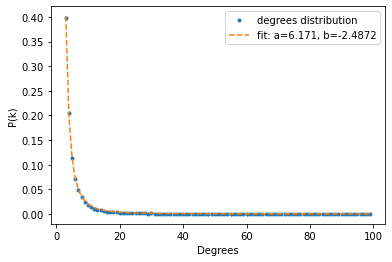

[39804, 20386, 11316, 7009, 4821, 3333, 2469, 1772, 1421, 1046, 868, 730, 605, 487, 413, 339, 329, 259, 226, 211, 143, 153, 126, 133, 113, 110, 79, 86, 82, 78, 64, 55, 45, 57, 45, 39, 27, 27, 29, 29, 33, 22, 32, 22, 12, 25, 17, 15, 17, 12, 17, 17, 9, 7, 10, 12, 12, 15, 11, 11, 12, 9, 3, 4, 9, 6, 7, 7, 14, 7, 6, 6, 8, 4, 8, 4, 8, 3, 4, 6, 3, 1, 3, 0, 4, 2, 1, 4, 5, 4, 1, 5, 2, 3, 2, 1, 5]


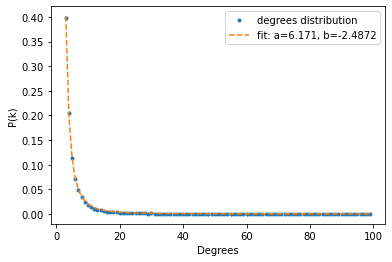

[39804, 20386, 11316, 7009, 4821, 3333, 2469, 1772, 1421, 1046, 868, 730, 605, 487, 413, 339, 329, 259, 226, 211, 143, 153, 126, 133, 113, 110, 79, 86, 82, 78, 64, 55, 45, 57, 45, 39, 27, 27, 29, 29, 33, 22, 32, 22, 12, 25, 17, 15, 17, 12, 17, 17, 9, 7, 10, 12, 12, 15, 11, 11, 12, 9, 3, 4, 9, 6, 7, 7, 14, 7, 6, 6, 8, 4, 8, 4, 8, 3, 4, 6, 3, 1, 3, 0, 4, 2, 1, 4, 5, 4, 1, 5, 2, 3, 2, 1, 5]


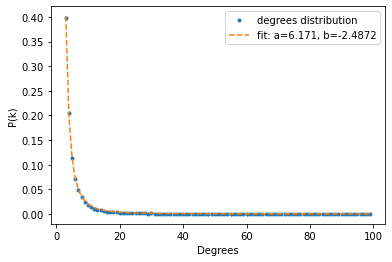

In [40]:
#N = [100000+i*100000 for i in range(1)]
N=1e5
M = 3

def power_law(x, a, b):
    return a*np.power(x, b)

G_s = barabasi_albert(N, M)

for i in range(3):
    G_s = barabasi_albert(N, M, initial_graph = G_s)
    k = np.arange(min([d for n,d in G_s.degree]), 100)
    p_k = [0]*len(k) #vettore delle y (p(k))

    k_mean =sum(k)/len(k)  
    

    for j in range(len(k)):
        for n,d in G_s.degree:
            if k[j] == d:
                p_k[j] += 1
    norm = sum(p_k) 
    
    for i in range(len(p_k)): #normalizzo il vettore p(k)
        p_k[i] = p_k[i]/norm
        

    fig, ax = plt.subplots()
    ax.plot(k, p_k, '.', label = 'degrees distribution')
    ax.set_xlabel("Degrees")
    ax.set_ylabel("P(k)")  
    
    # power fit
    
    poptPower, pcovPower = curve_fit(power_law, k, p_k) 
                                        
    fit_function = power_law(k, *poptPower)
    
    ax.plot(k, fit_function, '--',
               label = f"fit: a={round(poptPower[0],3)}, b={round(poptPower[1],4)}")
    ax.legend()
    
    plt.show()

   

In [45]:
expected = [np.power(x,-3.) for x in k]

for i in range(10):
    print( expected[i], 'vs: ', p_k[i])

#stats.chisquare(p_k, expected)

0.037037037037037035 vs:  0.39854615361509116
0.015625 vs:  0.20411923142390836
0.008 vs:  0.11330389594785377
0.004629629629629629 vs:  0.07017912749191473
0.0029154518950437317 vs:  0.04827130455678712
0.001953125 vs:  0.03337238292631642
0.0013717421124828531 vs:  0.024721396173139887
0.001 vs:  0.017742533016931503
0.0007513148009015778 vs:  0.014228069648453537
0.0005787037037037037 vs:  0.010473301092387331
